<a href="https://colab.research.google.com/github/SergeiVKalinin/Research-Projects/blob/main/Hypothesis/PySR_gpax_sin_reward_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook description
1. generate data
2. normal GP
3. PYSR-GPAX standard GP
4. Active learning standard GP

In [ ]:
!pip install -q pysr
!pip install -q gpax
!pip install -q arviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 987.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 29.2 MB/s eta 0:00:00


# Simulated data

In [ ]:
## functions:
import numpy as np
import matplotlib.pyplot as plt
onp = np

def sin_function(x, noise = 0.01):
    # Sine function is periodic, so showing a few periods is sufficient
    return np.sin(x) +  noise * np.random.randn(len(x))


Text(0.5, 1.0, 'sin_function')

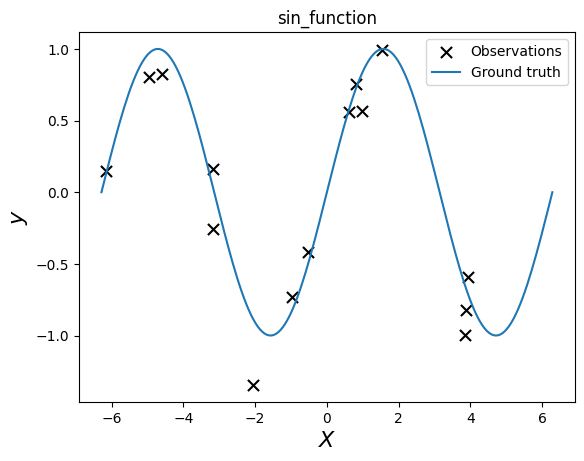

In [ ]:
#X_bounds = np.array([0, 10])
#X_unmeasured = np.linspace(X_bounds[0], X_bounds[1], 200)

title = 'sin_function'
x_range = np.linspace(-2*np.pi, 2*np.pi, 200)

fn = sin_function
# Create plots with optimal intervals
NUM_INIT_POINTS = 15 # number of observation points
X_measured = np.sort(np.random.uniform(x_range[0], x_range[-1], size=(NUM_INIT_POINTS,)))
X_unmeasured = (x_range)
y_measured = fn(X_measured, noise = 0.2)
y_unmeasured = fn(X_unmeasured, noise = 0.2)
ground_truth = fn(X_unmeasured, noise=0)



plt.xlabel("$X$", fontsize=16)
plt.ylabel("$y$", fontsize=16)
plt.scatter(X_measured, y_measured, marker='x', c='k', s=64, zorder=1, label="Observations", alpha=1.0)
plt.plot(X_unmeasured, ground_truth, label='Ground truth')
plt.legend(loc='best')
plt.title(title)



In [ ]:
# set variable names for gpax:
X = X_measured
y = y_measured
X_test = X_unmeasured
y_test = y_unmeasured
num_seed_points = len(X_measured)

# Setup PYSR utility functions

In [ ]:
# utility f;n's


import re
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from typing import Dict, List, Optional, Set, Tuple, Type, Union
import sympy as sp

def convert_to_jax_format(equations_data):
    """
    Given Pysrmodel.equations_ crates a format acceptable to "define_functions_and_return_executables_specific_format"
    Args:
        equations_data: list
    Returns:
        list


    Example:
    # iterate through dict:
      converted_equations_dict = {}
      for i,title in enumerate(titles):
        eqn_list_temp = pysr_eqn_dict[f"{title}"]
        converted_equations_dict[f"{title}"]  = convert_to_jax_format(eqn_list_temp)
    """
    # Initialize parameter names generator
    def param_names_gen():
        for i in range(26):  # Limit to 26 for simplicity, adjust if more needed
            yield chr(97 + i)  # Generates 'a', 'b', 'c', ...

    modified_equations = []
    param_gen = param_names_gen()

    for item in equations_data:
        equation = item
        sympy_eq = sp.sympify(equation, evaluate=False)



        # Convert sympy expression to string and replace math functions with jnp equivalents
        jax_eq_str = str(sympy_eq)
        jax_eq_str = jax_eq_str.replace("sin", "jnp.sin").replace("cos", "jnp.cos").replace("exp", "jnp.exp").replace("log", "jnp.log")

        # Replace 'x0' with 'x' for consistency
        jax_eq_str = jax_eq_str.replace("x0", "x")

        modified_equations.append(jax_eq_str)

    return modified_equations


def define_functions_and_return_executables_specific_format(modified_equations, title="func"):
    """
    Creates and executes the jax format function (also the prior)
    Args:
        modified_equations: list
        title: preceeding name of function
    Returns: list, list

    example:
    gpax_equations_dict = {}
    for i,title in enumerate(titles):
      eqn_list_temp = converted_equations_dict[f"{title}"]
      model_list, model_prior_list = define_functions_and_return_executables_specific_format(eqn_list_temp, title)
      gpax_equations_dict[f"{title}"]  = {"model_list": model_list, "model_prior_list": model_prior_list}
    """
    model_list = []
    model_prior_list = []

    # Function to extract numeric constants from the equation
    def find_constants(eq):
        # This regex finds all standalone numbers in the equation
        return set(re.findall(r'\b\d+\.?\d*|\.\d+\b', eq))

    # Generating parameter names sequentially
    def generate_param_names(start='a', count=26):
        for i in range(count):
            yield chr(ord(start) + i)



    for i, eq in enumerate(modified_equations, start=1):
        # Map x0 to x, x1 to y
        eq = eq.replace('x0', 'x').replace('x1', 'y')

        constants = find_constants(eq)

        param_name_gen = generate_param_names()
        param_map = {const: next(param_name_gen) for const in constants}

        # Replace constants in the equation with params dictionary access
        for const, param_name in param_map.items():
            eq = re.sub(r'\b' + const + r'\b', f'params["{param_name}"]', eq)

        # Define the model function
        func_name = f'{title}_guess_{i}'
        model_func_code = f"def {func_name}(x, params):\n    return {eq}\n"

        # Define the prior function with parameters
        prior_name = f'{func_name}_prior'
        prior_func_code = "def " + prior_name + "():\n    return {\n"
        for param_name in param_map.values():
            prior_func_code += f'        "{param_name}": numpyro.sample("{param_name}", dist.Normal(0, 1)),\n'
        prior_func_code += '    }\n'

        # Execute definitions
        print(i, model_func_code)

        try:
              exec(model_func_code, globals())
              exec(prior_func_code, globals())
              model_list.append(eval(func_name))
              model_prior_list.append(eval(prior_name))

        except:
          print(f"error{i}")




    return model_list, model_prior_list

def pysr_jax_get_best_eqn(model):
    """
    returns eqn
    """
    df = model.equations_
    eqn = [df.loc[df['score'].idxmax()]["equation"]] # also try best--> but need to get the equation automated?
    print(eqn)
    return eqn

def pysr_jax_get_3best_eqn(model):
    """
    Returns the best 2 equations based on score.
    """
    df = model.equations_
    # Sort by 'score' in descending order and select the top 2
    best_equations = df.sort_values(by='score', ascending=False).head(3)['equation'].tolist()
    print(best_equations)
    return best_equations



In [ ]:
from pysr import PySRRegressor

In [ ]:

model = PySRRegressor(
    niterations=5,
    binary_operators=["+", "*", "/", "-"],
    unary_operators=["sin", "cos", "exp", "log"],
    # model_selection="best",
    verbosity=1 )






In [ ]:
model.fit(X_measured.reshape(-1,1), y_measured.reshape(-1,1))


/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1309: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                            sin(x0)   
	1         1.174560e-01                               sin(x0) - 0.09338406   
	2         9.110763e-08                          sin(x0) - sin(0.09351134)   
	3   >>>>  1.208828e-01                  sin(x0 + 0.09743517) - 0.08174966   
	4         3.118749e-05             sin(x0 + sin(0.09743517)) - 0.08174966   
	5         4.228730e-03       sin(x0 + 0.09632483) + sin(sin(-0.09517446))   
	6         4.795885e-04  (cos(-0.03416162) * -0.090682805) + sin(x0 - -...   
	7         1.194330e-01  ((x0 / (x0 - -1.3381331)) * -0.11537431) + sin...   
	8         9.272813e-03  (sin(exp(exp(cos(cos(cos(x0)))) - x0)) * -0.14...   
	9         3.137037e-02  ((sin(exp(exp(cos(cos(cos(x0)))) - x0)) * -0.1...   
	10        5.824249e-02  sin(x0) + ((sin(exp(exp(cos(cos(cos(x0)))) - x...   
	
	        loss  complexity  
	0   0.041647           2  
	1   0.032928           4  
	2   0.032928           5  
	3   0.029179           6  
	4   0.029178           7  
	5   0.029055           8  
	6   0.029041           9  
	7   0.025772          10  
	8   0.024833          14  
	9   0.023323          16  
	10  0.020758          18  
]

In [ ]:
selected_pysr_eqn_list = pysr_jax_get_3best_eqn(model)
eqn_list_temp = convert_to_jax_format(selected_pysr_eqn_list)
model_list, model_prior_list = define_functions_and_return_executables_specific_format(eqn_list_temp, title=title)

['sin(x0 + 0.09743517) - 0.08174966', '((x0 / (x0 - -1.3381331)) * -0.11537431) + sin(x0)', 'sin(x0) - 0.09338406']
1 def sin_function_guess_1(x, params):
    return jnp.sin(x + params["a"]) - params["b"]*params["c"]

2 def sin_function_guess_2(x, params):
    return x*(-params["c"])/(x - params["b"]*(-params["a"])) + jnp.sin(x)

3 def sin_function_guess_3(x, params):
    return jnp.sin(x) - params["a"]*params["b"]



## Reward based active learning

In [ ]:
#@title Plotting and data utilities { form-width: "20%" }

def update_datapoints(point_idx, point_measured, X_measured, y_measured, X_unmeasured):
    """Updates "measured" and "unmeasured" arrays of (dummy) data points"""
    X_measured = jnp.append(X_measured, X_unmeasured[point_idx][None], 0)
    X_unmeasured = jnp.delete(X_unmeasured, point_idx, 0)
    y_measured = jnp.append(y_measured, point_measured)
    return X_measured, y_measured, X_unmeasured


def plot_results(X_measured, y_measured, X_unmeasured, y_pred, y_sampled, obj, model_idx, rewards, **kwargs):
    X = jnp.concatenate([X_measured, X_unmeasured], axis=0).sort()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(X_measured, y_measured, marker='x', s=100, c='k', label="Measured points", zorder=1)
    ax1.plot(X, y_pred, c='red', label='Model reconstruction', zorder=0)
    ax1.fill_between(X, y_pred - y_sampled.std(0), y_pred + y_sampled.std(0),
                     color='r', alpha=0.2, label="Model uncertainty", zorder=0)
    ax1.set_xlabel("$x$", fontsize=18)
    ax1.set_ylabel("$y$", fontsize=18)
    ax2.plot(X_unmeasured, obj, c='k')
    ax2.vlines(X_unmeasured[obj.argmax()], obj.min(), obj.max(), linestyles='dashed', label= "Next point")
    ax2.set_xlabel("$x$", fontsize=18)
    ax2.set_ylabel("Acquisition function", fontsize=18)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper left")
    step = kwargs.get("e", 0)
    plt.suptitle("Step: {},  Sampled Model: {}, Rewards: {}".format(
        step+1, model_idx, np.around(rewards, 3).tolist()), fontsize=24)
    # fig.savefig("./{}.png".format(step))
    plt.show()


def plot_acq(x, obj, idx):
    plt.plot(x.squeeze(), obj, c='k')
    plt.vlines(x[idx], obj.min(), obj.max(), linestyles='dashed')
    plt.xlabel("$x$", fontsize=18)
    plt.ylabel("Acquisition function", fontsize=18)
    plt.show()


def plot_final_result(X, y, X_unmeasured, y_pred, y_sampled, seed_points):
    plt.figure(figsize=(6, 4))
    plt.scatter(X[seed_points:], y[seed_points:], c=jnp.arange(1, len(X[seed_points:])+1),
                cmap='viridis', label="Sampled points", zorder=2)
    cbar = plt.colorbar(label="Exploration step")
    cbar_ticks = jnp.arange(2, len(X[seed_points:]) + 1, 2)
    cbar.set_ticks(cbar_ticks)
    plt.scatter(X[:seed_points], y[:seed_points], marker='x', s=64,
                c='k', label="Seed points", zorder=1)
    plt.plot(X_unmeasured, y_pred, '--', c='red', label='Model reconstruction', zorder=1)
    plt.plot(X_unmeasured, truefunc, c='k', label="Ground truth", zorder=0)
    plt.fill_between(X_unmeasured, y_pred - y_sampled.std(0), y_pred + y_sampled.std(0),
                            color='r', alpha=0.2, label="Model uncertainty", zorder=0)
    plt.xlabel("$x$", fontsize=12)
    plt.ylabel("$y$", fontsize=12)
    plt.legend(fontsize=9, loc='upper left')
    #plt.ylim(1.8, 6.6)
    plt.show()

In [ ]:
#Let's also specify custom priors over GP kernel (this step is optional):


def gp_kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.Uniform(0, 1))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    return {"k_length": length, "k_scale": scale}

In [ ]:
# Define a simple reward function for hypothesis learning:
def get_reward(obj_history):
    """A reward of +/-1 is given if the median uncertainty at the current step
    is smaller/larger than the median uncertainty at the previous step"""
    r = 1 if obj_history[-1] < obj_history[-2] else -1
    return r

In [ ]:
# Create lists containing physical models and probabilistic priors over their parameters
exploration_steps = 15
warmup_steps = 3

models = model_list[-3:]
model_priors = model_prior_list[-3:]

record = np.zeros((len(model_list), 2))
model_choices = []
obj_history = []


In [ ]:
import os
if os.environ.get("CI_SMOKE"):
    NUM_WARMUP = 100
    NUM_SAMPLES = 100
else:
    NUM_WARMUP = 2000
    NUM_SAMPLES = 2000

In [ ]:
np.random.seed(1)  # rng seed for reproducibility



# Warm-up phase
for w in range(warmup_steps):
    print("Warmup step {}/{}".format(w+1, warmup_steps))
    obj_median_all, obj_all = [], []

    # Iterate over probabilistic models in the list
    for i, model in enumerate(models):

        # for each model, run BI and store uncertainty values
        obj, _ = gpax.hypo.step(
            model,
            model_priors[i],
            X_measured,
            y_measured,
            X_unmeasured,
            gp_wrap=True,
            gp_kernel='Matern',
            gp_kernel_prior=gp_kernel_prior,  # wrap model into a Gaussian process
            num_warmup=NUM_WARMUP,
            num_samples=NUM_SAMPLES,
        )
        record[i, 0] += 1
        obj_all.append(obj)

        # (one can use integral uncertainty instead of median)
        obj_median_all.append(jnp.nanmedian(obj).item())

    # Reward a model that has the smallest integral/median uncertainty
    idx = np.argmin(obj_median_all)
    model_choices.append(idx)
    record[idx, 1] += 1

    # Store the integral/median uncertainty
    obj_history.append(obj_median_all[idx])

    # Compute the next measurement point using the predictive uncertainty of rewarded model
    obj = obj_all[idx]
    next_point_idx = obj.argmax()

    # Evaluate the function in the suggested point
    measured_point =  y_unmeasured[next_point_idx]

    # Update arrays with measured and unmeasured points
    X_measured, y_measured, X_unmeasured = update_datapoints(
        next_point_idx, measured_point, X_measured, y_measured, X_unmeasured
    )




Warmup step 1/3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:07<00:00, 528.61it/s, 7 steps of size 3.08e-01. acc. prob=0.83] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.12      0.23      0.11     -0.23      0.49   1075.08      1.00
         b     -0.02      0.62     -0.02     -1.06      1.04    649.17      1.00
         c     -0.04      0.62     -0.03     -0.94      1.05    516.73      1.00
  k_length      0.60      0.28      0.64      0.18      1.00   1012.33      1.00
   k_scale      0.15      0.14      0.12      0.01      0.30    924.03      1.00
     noise      0.11      0.07      0.09      0.02      0.20    782.12      1.00



/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:08<00:00, 488.76it/s, 15 steps of size 1.85e-01. acc. prob=0.68]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.10      0.84     -0.07     -1.47      1.14     23.05      1.04
         b     -0.10      0.85     -0.12     -1.62      1.23     42.90      1.00
         c      0.07      0.15      0.06     -0.16      0.31    416.05      1.00
  k_length      0.56      0.28      0.61      0.13      0.99    158.31      1.00
   k_scale      0.13      0.12      0.10      0.02      0.27    402.64      1.00
     noise      0.10      0.07      0.08      0.03      0.19     67.93      1.00



/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 597.91it/s, 9 steps of size 2.95e-01. acc. prob=0.85]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.01      0.58     -0.00     -1.01      1.02    546.46      1.00
         b     -0.05      0.58     -0.03     -0.91      1.04    591.11      1.00
  k_length      0.59      0.27      0.63      0.17      1.00   1530.81      1.00
   k_scale      0.13      0.12      0.10      0.02      0.27    939.71      1.00
     noise      0.10      0.07      0.08      0.03      0.18    965.43      1.00

Warmup step 2/3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 606.35it/s, 9 steps of size 3.50e-01. acc. prob=0.73] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.10      0.19      0.10     -0.17      0.44    650.65      1.01
         b     -0.11      0.66     -0.03     -1.38      0.91    124.28      1.00
         c     -0.00      0.57     -0.03     -1.01      0.97    505.63      1.00
  k_length      0.57      0.28      0.59      0.16      1.00    505.52      1.00
   k_scale      0.13      0.10      0.10      0.02      0.24    805.19      1.00
     noise      0.10      0.06      0.08      0.03      0.18   1004.21      1.00



/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:48<00:00, 81.71it/s, 1023 steps of size 1.55e-04. acc. prob=0.77]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.52      0.01      0.52      0.51      0.53      3.55      1.78
         b     -0.84      0.00     -0.85     -0.85     -0.84      7.27      1.18
         c      0.12      0.04      0.12      0.08      0.18      2.89      2.06
  k_length      0.00      0.00      0.00      0.00      0.00      2.45      2.58
   k_scale      0.20      0.00      0.20      0.20      0.20      3.57      1.61
     noise      0.11      0.00      0.11      0.10      0.11      2.48      2.84



/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 607.67it/s, 15 steps of size 3.01e-01. acc. prob=0.81]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.03      0.58     -0.01     -1.15      0.84    376.48      1.00
         b     -0.03      0.63     -0.01     -1.06      1.00    322.95      1.00
  k_length      0.57      0.28      0.61      0.17      1.00   1042.01      1.00
   k_scale      0.11      0.09      0.09      0.01      0.21    893.13      1.00
     noise      0.09      0.05      0.07      0.03      0.16    859.46      1.00

Warmup step 3/3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:07<00:00, 556.21it/s, 7 steps of size 3.29e-01. acc. prob=0.75] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.07      0.17      0.07     -0.21      0.34    597.60      1.01
         b      0.00      0.54      0.00     -0.92      0.92    565.57      1.00
         c      0.07      0.64      0.02     -0.99      1.26    199.94      1.01
  k_length      0.58      0.29      0.62      0.15      1.00    740.65      1.00
   k_scale      0.11      0.09      0.09      0.02      0.23    592.07      1.00
     noise      0.09      0.06      0.07      0.02      0.16    594.27      1.00



/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:11<00:00, 350.72it/s, 127 steps of size 2.30e-02. acc. prob=0.97]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.22      0.77     -0.15     -1.47      1.11     31.32      1.00
         b     -0.07      0.88     -0.06     -1.47      1.53     27.05      1.09
         c      0.06      0.11      0.06     -0.12      0.25    722.26      1.00
  k_length      0.55      0.28      0.59      0.12      0.99   1107.50      1.00
   k_scale      0.10      0.08      0.08      0.01      0.20    890.62      1.00
     noise      0.08      0.05      0.07      0.02      0.14    674.08      1.00



/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:07<00:00, 553.52it/s, 3 steps of size 2.93e-01. acc. prob=0.84] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.04      0.53     -0.04     -0.98      0.87    571.75      1.00
         b     -0.05      0.58     -0.04     -1.04      0.80    440.92      1.00
  k_length      0.56      0.29      0.59      0.11      1.00    657.50      1.00
   k_scale      0.10      0.08      0.08      0.01      0.19    914.63      1.00
     noise      0.08      0.05      0.07      0.02      0.14   1029.10      1.00



In [ ]:
# Average over the number of warmup steps
record[:, 1] = record[:, 1] / warmup_steps

In [ ]:
X = jnp.concatenate([X_measured, X_unmeasured], axis=0).sort()
X.shape

(215,)

Exploration step 4/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:06<00:00, 598.71it/s, 15 steps of size 2.74e-01. acc. prob=0.81] 


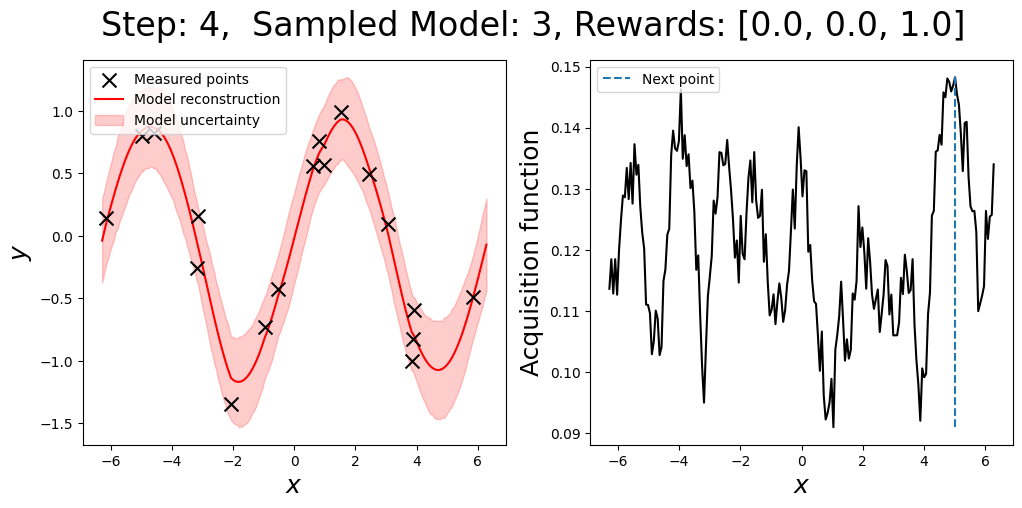

Exploration step 5/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:07<00:00, 557.06it/s, 15 steps of size 2.19e-01. acc. prob=0.84]


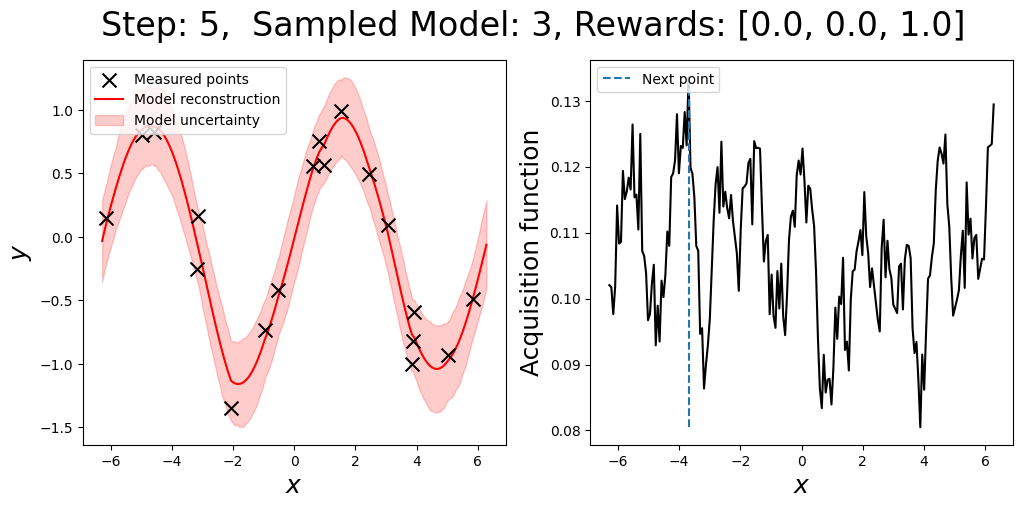

Exploration step 6/15
Using model 2


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:11<00:00, 348.23it/s, 127 steps of size 3.03e-02. acc. prob=0.89]
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:15<0

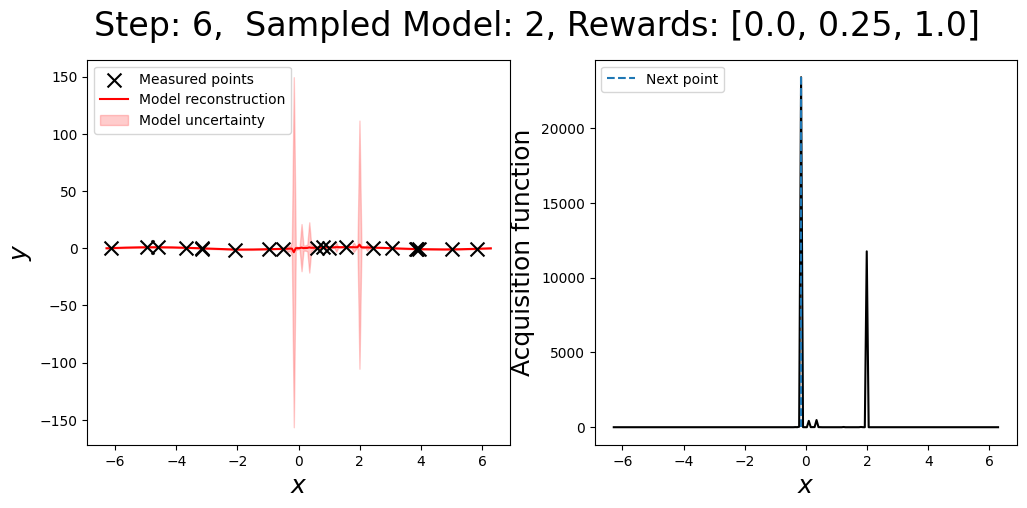

Exploration step 7/15
Using model 1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:08<00:00, 490.48it/s, 21 steps of size 2.80e-01. acc. prob=0.78] 


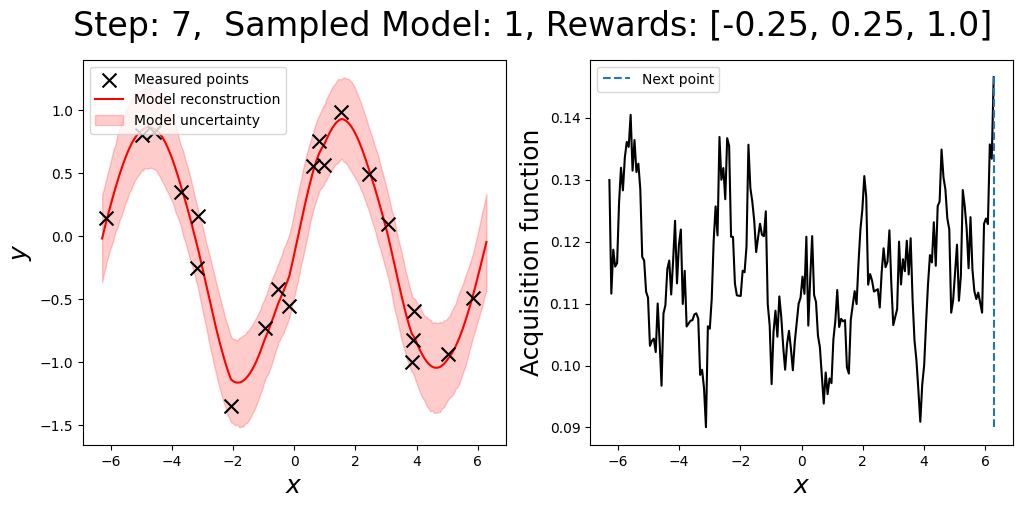

Exploration step 8/15
Using model 2


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:09<00:00, 401.33it/s, 31 steps of size 8.48e-02. acc. prob=0.73]


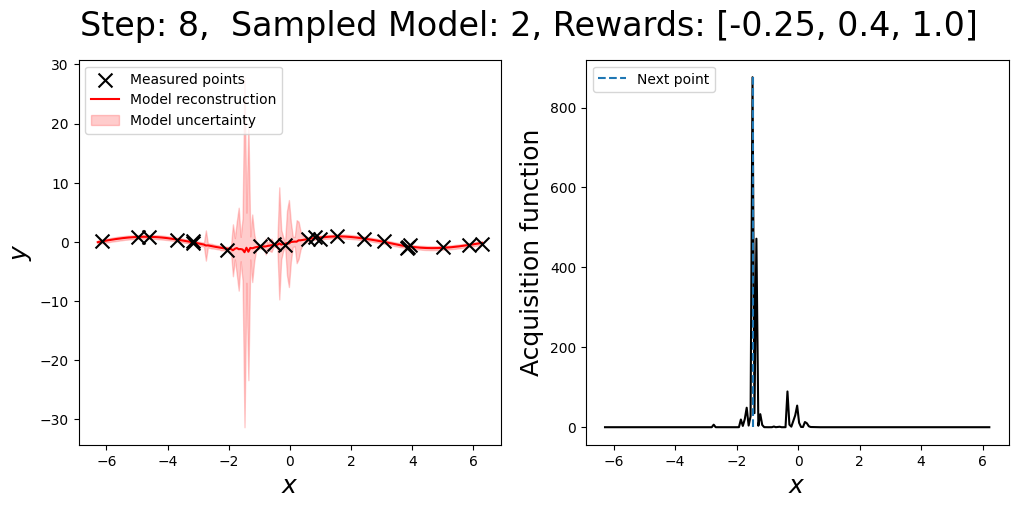

Exploration step 9/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:08<00:00, 493.22it/s, 15 steps of size 2.37e-01. acc. prob=0.75]


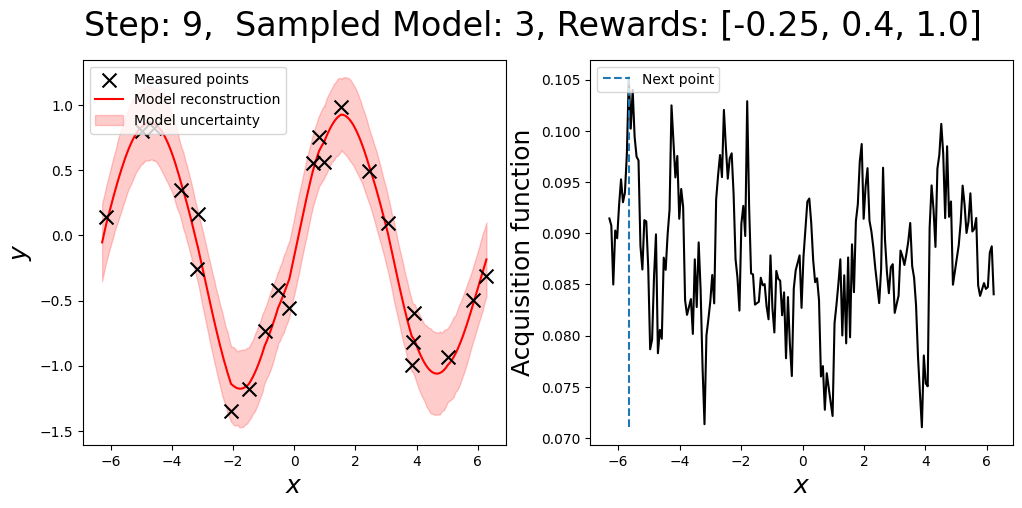

Exploration step 10/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:07<00:00, 524.61it/s, 15 steps of size 2.90e-01. acc. prob=0.74] 


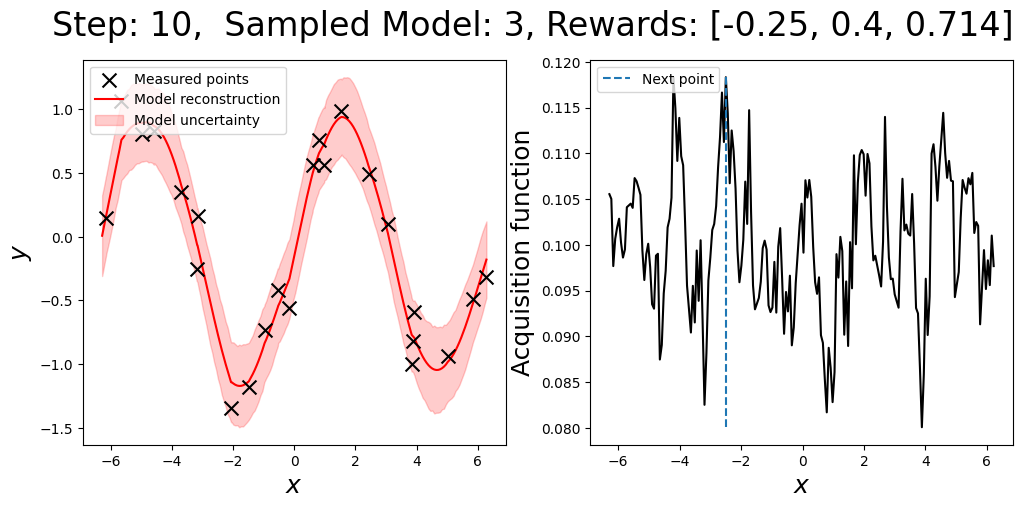

Exploration step 11/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:07<00:00, 548.71it/s, 15 steps of size 2.28e-01. acc. prob=0.84]


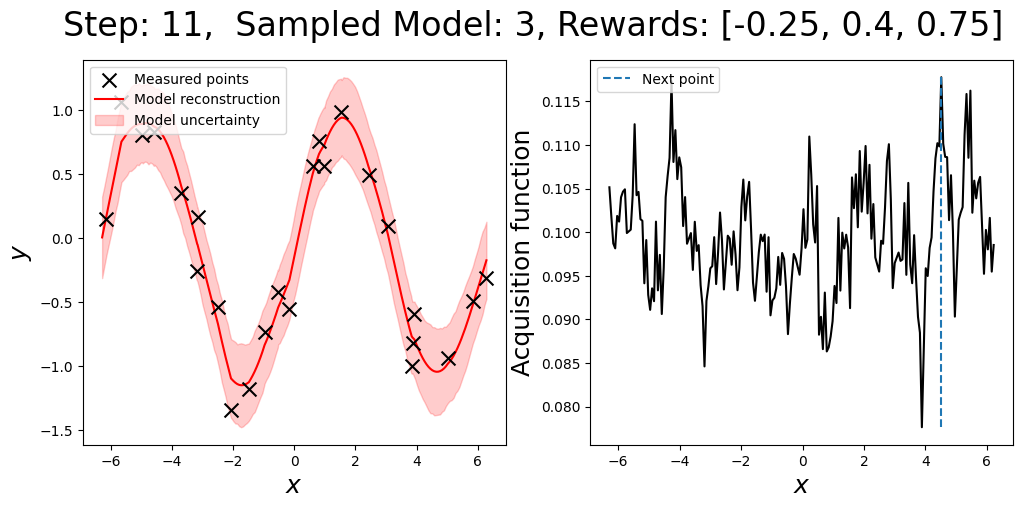

Exploration step 12/15
Using model 1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:08<00:00, 473.97it/s, 9 steps of size 3.66e-01. acc. prob=0.67]  


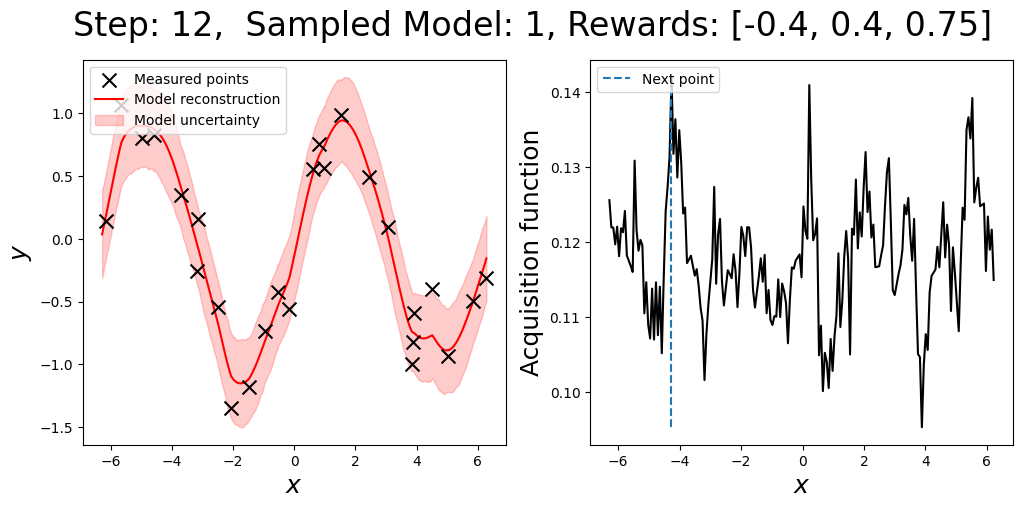

Exploration step 13/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:08<00:00, 465.91it/s, 11 steps of size 2.64e-01. acc. prob=0.81] 


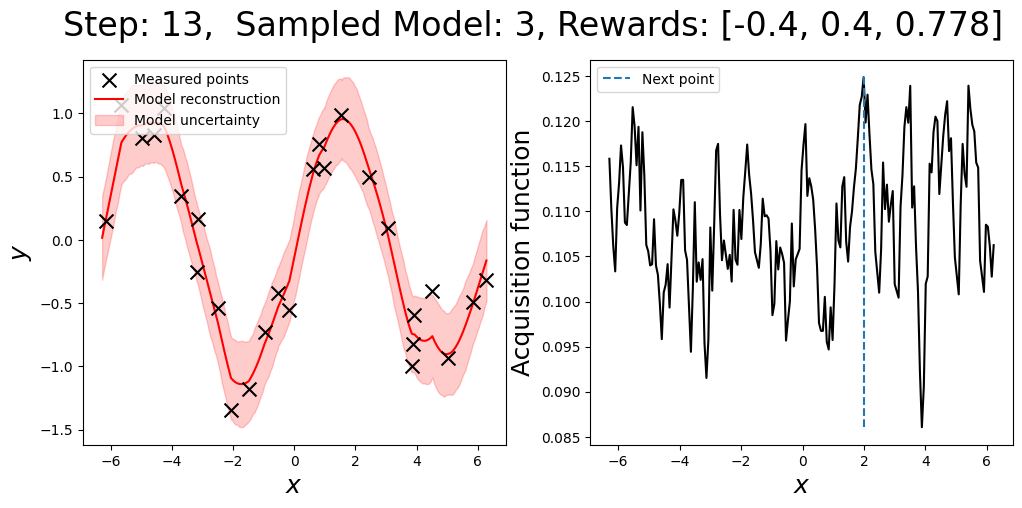

Exploration step 14/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:10<00:00, 399.75it/s, 9 steps of size 2.77e-01. acc. prob=0.86]


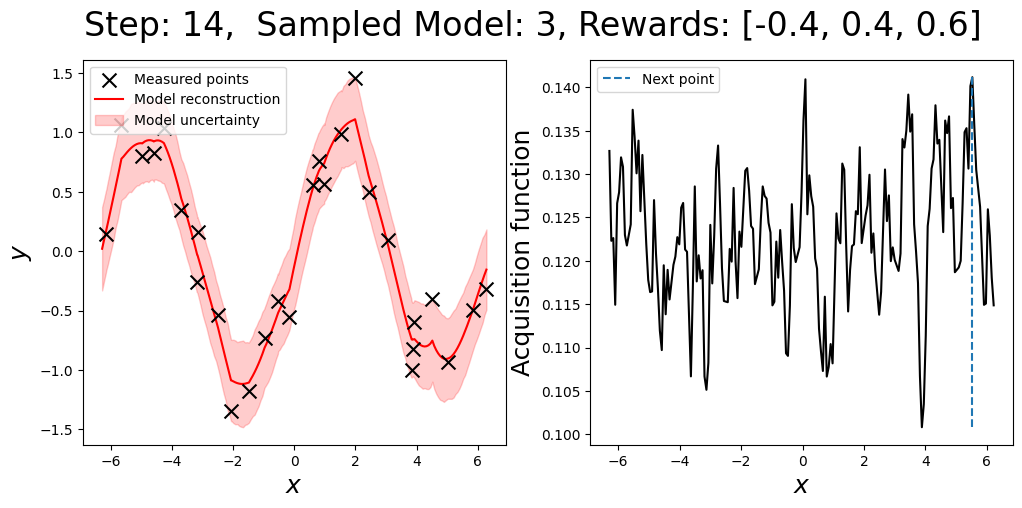

Exploration step 15/15
Using model 3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [00:08<00:00, 453.25it/s, 15 steps of size 2.64e-01. acc. prob=0.82]


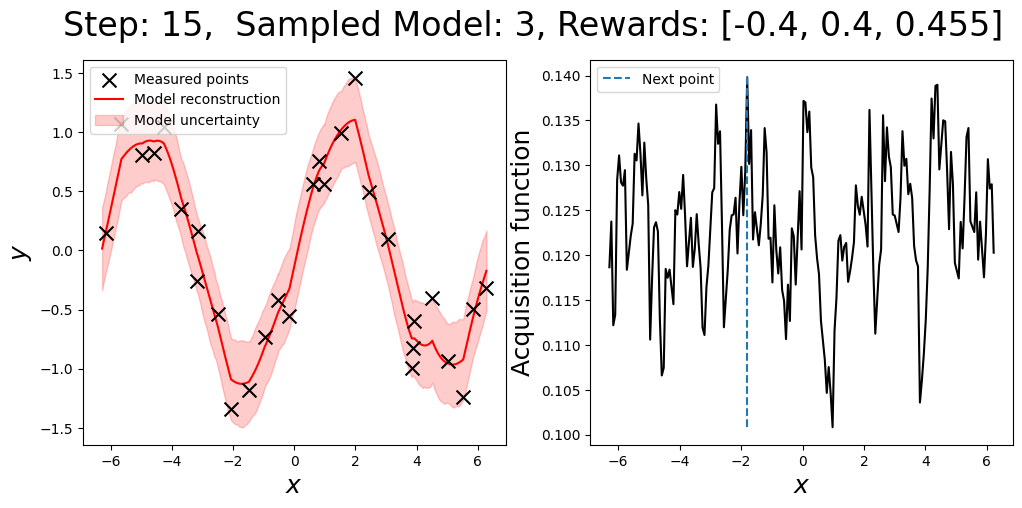

In [ ]:
# Run exploration phase
plot_reconstruction = True
for e in range(exploration_steps - warmup_steps):
    print("Exploration step {}/{}".format(e+warmup_steps+1, exploration_steps))

    # Choose model according to epsilon-greedy policy
    idx = gpax.hypo.sample_next(record[:, 1], method="eps-greedy", eps=0.4)
    model_choices.append(idx)
    print("Using model {}".format(idx+1))

    # Derive acquisition function with the selected model
    obj, m_post = gpax.hypo.step(
        models[idx],
        model_priors[idx],
        X_measured,
        y_measured,
        X_unmeasured,
        gp_wrap=True,
        gp_kernel='Matern',
        gp_kernel_prior=gp_kernel_prior,  # wrap the sampled model into a Gaussian process
        num_restarts=2,
        print_summary=False,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
    )

    # Get reward
    obj_history.append(jnp.nanmedian(obj).item())
    r = get_reward(obj_history)

    # Update records
    record = gpax.hypo.update_record(record, idx, r)

    # Get the next measurement point from the predictive uncertainty of the sampled model
    next_point_idx = obj.argmax()

    # Evaluate function in the suggested point
    measured_point = y_unmeasured[next_point_idx]

    if plot_reconstruction:

        # plot current reconstruction and acqusition function
        y_pred, y_sampled = m_post.predict(gpax.utils.get_keys()[1], X)
        plot_results(
            X_measured,
            y_measured,
            X_unmeasured,
            y_pred,
            y_sampled.squeeze(),
            obj,
            idx+1,
            record[:, 1],
            e=e+warmup_steps
        )

    # Update arrays with measured and unmeasured points
    X_measured, y_measured, X_unmeasured = update_datapoints(
        next_point_idx,
        measured_point,
        X_measured,
        y_measured,
        X_unmeasured
    )

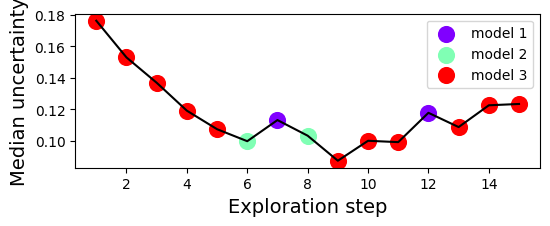

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
cmap = mpl.colormaps["rainbow"].resampled(3)
ax.plot(np.arange(1, exploration_steps+1), obj_history[-15:], c='k')
for model_index in range(3):
    where = np.where(np.array(model_choices) == model_index)[0]
    ax.scatter(
        where + 1,
        np.array(obj_history)[where],
        color=cmap(model_index),
        s=128,
        alpha=1,
        label=f"model {model_index+1}",
    )
ax.set_xlabel("Exploration step", fontsize=14)
ax.set_ylabel("Median uncertainty", fontsize=14)
ax.legend()
plt.show()

In [ ]:
for i, r in enumerate(record):
    print("model {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), np.round(r[1], 3)))

model 1:  counts 5  reward (avg) -0.4
model 2:  counts 5  reward (avg) 0.4
model 3:  counts 11  reward (avg) 0.455
